<a href="https://colab.research.google.com/github/santolina/Convolutional-Neural-Networks-in-TensorFlow/blob/master/Course_4_S%2BP_Week_4_Lesson_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install tensorflow==2.0.0b1
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [11]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2019-11-26 15:01:04--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 2404:6800:4008:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2019-11-26 15:01:04 (119 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



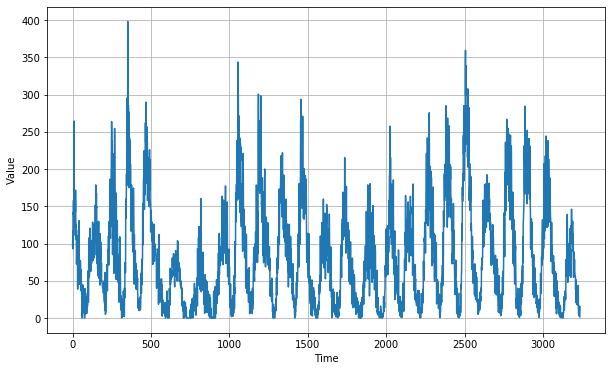

In [5]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

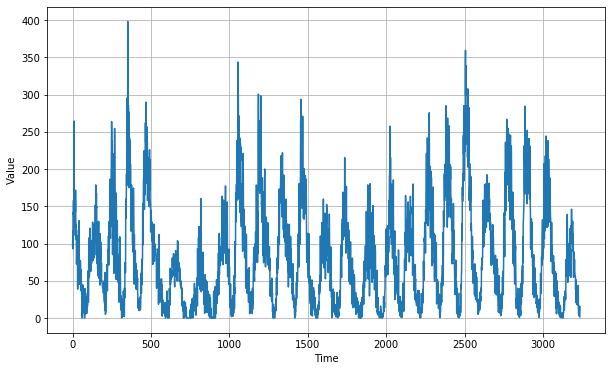

In [6]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 256 #64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose=1)




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
11/11 [==============================] - 4s 351ms/step - loss: 95.3357 - mae: 95.6555
Epoch 2/100
11/11 [==============================] - 1s 90ms/step - loss: 92.7160 - mae: 93.5649
Epoch 3/100
11/11 [==============================] - 1s 89ms/step - loss: 89.3284 - mae: 90.0611
Epoch 4/100
11/11 [==============================] - 1s 91ms/step - loss: 84.0431 - mae: 84.6978
Epoch 5/100
11/11 [==============================] - 1s 91ms/step - loss: 77.7900 - mae: 78.3874
Epoch 6/100
11/11 [==============================] - 1s 89ms/step - loss: 71.5165 - mae: 72.1228
Epoch 7/100
11/11 [==============================] - 1s 87ms/step - loss: 65.6733 - mae: 66.3448
Epoch 8/100
11/11 [==============================] - 1s 87ms/step - loss: 60.7028 - mae: 61.3503
Epoch 9/100
11/11 [==============================] - 1s 89ms/step - loss: 56.5380 - mae: 57.1504
Epoch 10/100
11/11 [====

[1e-08, 0.0001, 0, 60]

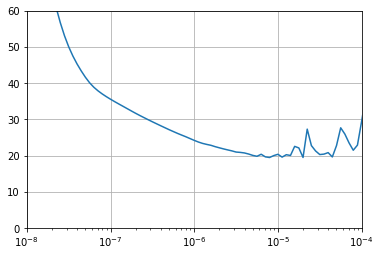

In [22]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.grid(True)
plt.axis([1e-8, 1e-4, 0, 60])

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


#️optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
optimizer = tf.keras.optimizers.SGD(lr=0.5e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
28/28 [==============================] - 4s 139ms/step - loss: 42.4139 - mae: 43.1509
Epoch 2/500
28/28 [==============================] - 1s 42ms/step - loss: 25.2925 - mae: 25.7790
Epoch 3/500
28/28 [==============================] - 1s 42ms/step - loss: 21.3491 - mae: 21.8447
Epoch 4/500
28/28 [==============================] - 1s 45ms/step - loss: 19.8295 - mae: 20.3111
Epoch 5/500
28/28 [==============================] - 1s 42ms/step - loss: 18.8734 - mae: 19.3684
Epoch 6/500
28/28 [==============================] - 1s 43ms/step - loss: 18.3485 - mae: 18.8448
Epoch 7/500
28/28 [==============================] - 1s 43ms/step - loss: 18.0314 - mae: 18.5282
Epoch 8/500
28/28 [==============================] - 1s 41ms/step - loss: 17.9231 - mae: 18.4072
Epoch 9/500
28/28 [==============================] - 1s 44ms/step - loss: 17.9684 - mae: 18.4501
Epoch 10/500
28/28 [==============================] - 1s 42ms/step - loss: 17.6816 - mae: 18.1796
Epoch 11/500
28/28 [========

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

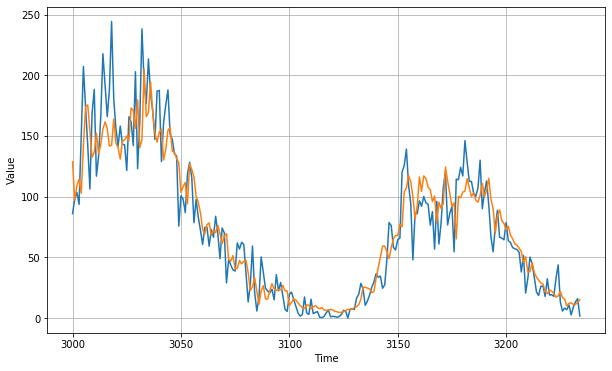

In [26]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.986698

In [27]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.3073635

<Figure size 432x288 with 0 Axes>

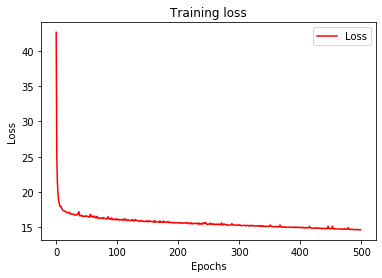

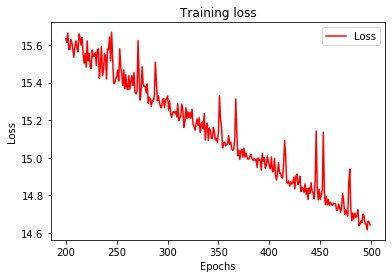

<Figure size 432x288 with 0 Axes>

In [28]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [29]:
print(rnn_forecast)

[128.63618    96.88362   109.090515  114.30154   102.88792   142.09213
 174.08333   175.60661   154.27644   132.30365   136.53152   152.21722
 135.43047   142.54932   155.7396    161.51692   156.16096   141.59279
 142.29741   164.0204    143.99211   140.19102   130.95363   145.50594
 146.61014   149.96829   146.11374   172.94998   170.98482   156.24748
 179.72182   140.38147   146.89644   205.23393   165.8945    169.4291
 194.54643   169.22299   152.26001   144.8452    153.15599   155.41779
 130.1552    139.06847   154.52603   157.09856   137.27443   136.54767
 131.41632   127.761505  103.30602   108.18391   111.60052    94.04252
 127.067184  122.35877   116.052124  100.28875    95.3197     86.64799
  73.172      69.1367     76.89018    78.317474   68.01959    72.2083
  70.2852     76.40977    69.639595   61.25444    67.7691     69.362
  48.05527    46.858997   51.409878   40.522163   40.812187   47.52791
  44.54785    46.71853    47.71172    37.507492   22.655869   25.818073
  33.1649

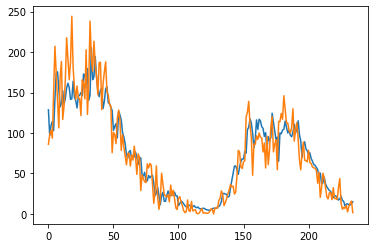

In [31]:
plt.plot(rnn_forecast, label='pred')
plt.plot(x_valid, label='org')